In [1]:
import h5py
import numpy as np
from PIL import Image
from IPython.display import display
from skimage import color
from skimage.metrics import structural_similarity as ssim
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from tqdm import tqdm

In [2]:
predictions = {
    'Adden1':h5py.File('dataset/prediction_ADDEN_1.h5','r'),
    'MLL':h5py.File('dataset/prediction_MLL.h5','r'),
    'Adden2':h5py.File('dataset/prediction_ADDEN_2.h5','r')
}

def rescale(x,x_min=None,x_max=None):
    if x_min is None:
        x_min = x.min()
    if x_max is None:
        x_max = x.max()
    return (x - x_min)/(x_max - x_min)

def colour_histogram(x):
    r = np.histogram(x[:,:,0],255,[0,255])
    g = np.histogram(x[:,:,1],255,[0,255])
    b = np.histogram(x[:,:,2],255,[0,255])
    
    return r,g,b

def plot_colour_histograms(a,b=None,title=None):
    for h,c in zip(a,['red','green','blue']):
        plt.plot(h[1][:255],h[0]/h[0].sum(),color=c)
    if b is not None:
        for h,c in zip(b,['red','green','blue']):
            plt.plot(h[1][:255],-h[0]/h[0].sum(),color=c,linestyle='-.')
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.show()

def display_images(a,b,r=4):
    compounded_image = np.concatenate([a,b],axis=1)
    compounded_image = compounded_image[::4,::4,:]
    display(Image.fromarray(compounded_image))

# Load images and process them

In [3]:
N = 1000

all_histograms = {key:{'original':[],'prediction':[]}
                  for key in predictions}
all_lab = {key:{'original':[],'prediction':[]}
           for key in predictions}
all_ssim = {key:[] for key in predictions}
for curr_dataset in predictions:
    all_keys = list(predictions[curr_dataset].keys())
    all_keys = np.random.choice(all_keys,N,replace=False)
    print(curr_dataset)
    
    all_images = {}
    
    print("Retrieving all images...")
    for key in tqdm(all_keys):
        image = predictions[curr_dataset][key]['image'][()]
        prediction = predictions[curr_dataset][key]['prediction'][()]
        all_images[key] = [image,prediction]
        
    x_min = np.quantile([all_images[x][1].min() for x in all_images],0.05)
    x_max = np.quantile([all_images[x][1].max() for x in all_images],0.95)
    print(x_min,x_max)
    print("Rescaling...")
    for k in tqdm(all_keys):
        image,prediction = all_images[k]
        all_images[k] = [
            np.uint8(image*255),
            np.uint8(rescale(prediction,x_min,x_max)*255)]
    print("Calculating histograms...")
    for key in tqdm(all_keys):
        image = all_images[key][0]
        prediction = all_images[key][1]
        
        image_histogram = colour_histogram(image)
        prediction_histogram = colour_histogram(prediction)
        
        all_histograms[curr_dataset]['original'].append(
            image_histogram)
        all_histograms[curr_dataset]['prediction'].append(
            prediction_histogram)
        
    print("Calculating std(L), std(a) and std(b)...")
    for key in tqdm(all_keys):
        image = all_images[key][0]
        prediction = all_images[key][1]

        lab_image = color.rgb2lab(image)
        lab_prediction = color.rgb2lab(prediction)
        
        all_lab[curr_dataset]['original'].append(
            np.std(lab_image.reshape([-1,3]),axis=0))
        all_lab[curr_dataset]['prediction'].append(
            np.std(lab_prediction.reshape([-1,3]),axis=0))
        
    print("Calculating structural similarity with original...")
    for key in tqdm(all_keys):
        image = all_images[key][0]
        prediction = all_images[key][1]
             
        all_ssim[curr_dataset].append(
            ssim(image,prediction,multichannel=True))

Adden1
Retrieving all images...


100%|██████████| 1000/1000 [00:39<00:00, 25.36it/s]


-0.08244730792939663 1.0141363263130188
Rescaling...


100%|██████████| 1000/1000 [00:04<00:00, 215.91it/s]


Calculating histograms...


100%|██████████| 1000/1000 [00:21<00:00, 45.95it/s]


Calculating std(L), std(a) and std(b)...


100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


Calculating structural similarity with original...


100%|██████████| 1000/1000 [01:56<00:00,  8.55it/s]


MLL
Retrieving all images...


100%|██████████| 1000/1000 [01:33<00:00, 10.75it/s]


-0.06761881969869137 0.9912979602813721
Rescaling...


100%|██████████| 1000/1000 [00:02<00:00, 470.51it/s]


Calculating histograms...


100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Calculating std(L), std(a) and std(b)...


100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


Calculating structural similarity with original...


100%|██████████| 1000/1000 [01:33<00:00, 10.66it/s]


Adden2
Retrieving all images...


100%|██████████| 1000/1000 [00:44<00:00, 22.55it/s]


0.005589420534670354 0.9672043472528458
Rescaling...


100%|██████████| 1000/1000 [00:02<00:00, 412.11it/s]


Calculating histograms...


100%|██████████| 1000/1000 [00:21<00:00, 46.21it/s]


Calculating std(L), std(a) and std(b)...


100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


Calculating structural similarity with original...


100%|██████████| 1000/1000 [01:32<00:00, 10.77it/s]


# Metrics

## Histogram distance (sum of squared errors)

The mapping appears to correctly transform images into more identical colour distributions. Particularly, the distance between histograms is minimised when all images are transformed.

In [4]:
histograms_for_plot = {}

for k in all_histograms:
    original = all_histograms[k]['original']
    prediction = all_histograms[k]['prediction']
    accumulator_original = {
        'r':np.zeros((all_histograms[k]['original'][0][0][0].size)),
        'g':np.zeros((all_histograms[k]['original'][0][0][0].size)),
        'b':np.zeros((all_histograms[k]['original'][0][0][0].size))}
    accumulator_prediction = {
        'r':np.zeros((all_histograms[k]['original'][0][0][0].size)),
        'g':np.zeros((all_histograms[k]['original'][0][0][0].size)),
        'b':np.zeros((all_histograms[k]['original'][0][0][0].size))}

    t = 0
    for a,b in zip(original,prediction):
        for i,c in enumerate(['r','g','b']):
            accumulator_original[c] += a[i][0]
            accumulator_prediction[c] += b[i][0]
        t += 1
    
    plotable_hist = [[],[]]
    for c in ['r','g','b']:
        accumulator_original[c] /= t
        accumulator_prediction[c] /= t

        accumulator_original[c] /= accumulator_original[c].sum()
        accumulator_prediction[c] /= accumulator_prediction[c].sum()
        
        plotable_hist[0].append(
            (accumulator_original[c],[i for i in range(0,256)]))
        plotable_hist[1].append(
            (accumulator_prediction[c],[i for i in range(0,256)]))
    
    histograms_for_plot[k] = plotable_hist

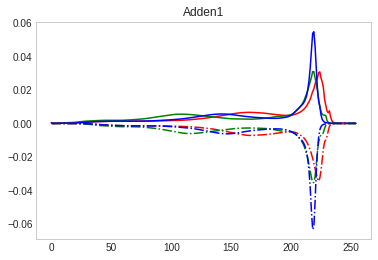

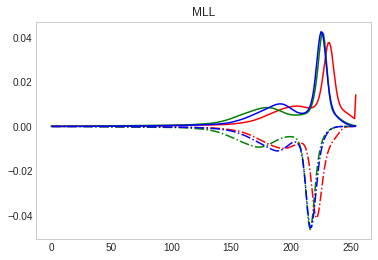

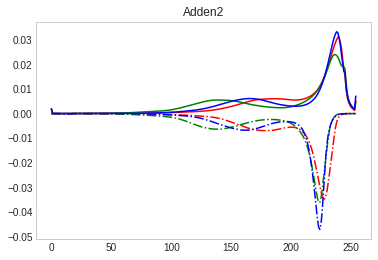

In [5]:
for k in histograms_for_plot:
    a,b = histograms_for_plot[k]
    plot_colour_histograms(a,b,k)

In [6]:
def histogram_distance(a,b):
    O = (a-b)**2 / (a+b)
    O = O[~np.isnan(O)]
    return np.sum(O)

def ssdh(a,b):
    return np.sum((a-b)**2)

all_keys = ['MLL','Adden1','Adden2']

all_combinations = product(
    product([0,1,2],[0,1]),
    product([0,1,2],[0,1]))

distance_array = np.zeros((3,3,2,2,3))

for (k1,i1),(k2,i2) in all_combinations:
    for c in range(3):
        A = histograms_for_plot[all_keys[k1]][i1][c][0]
        B = histograms_for_plot[all_keys[k2]][i2][c][0]

        distance_array[k1,k2,i1,i2,c] = histogram_distance(A,B)
        
distance_array = distance_array

/hps/research/gerstung/josegcpa/projects/01IMAGE/u-net-tf-2/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [7]:
distance_array.mean(0).mean(0).mean(-1)

array([[0.38771989, 0.43347197],
       [0.43347197, 0.20734406]])

## Structural similarity

Ideally, this should be close to 1 for all cohorts. As observable, this checks out.

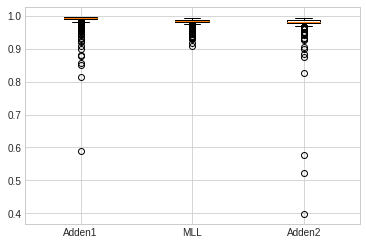

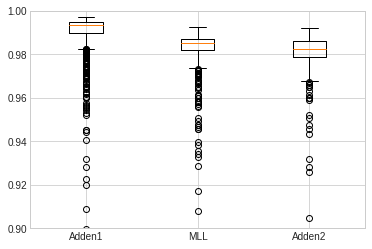

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
bp = plt.boxplot(
    [all_ssim[k] for k in all_ssim])

ax.set_xticklabels([k for k in all_ssim])

fig = plt.figure()
ax = fig.add_subplot(111)
bp = plt.boxplot(
    [all_ssim[k] for k in all_ssim])

ax.set_xticklabels([k for k in all_ssim])

ax.set_ylim([0.9,1])

plt.show()

## Colour richness

While not necessarily the best metric for our purpose, we should try not to decrease the colour richness upon image transformation. This is generally the case.

In [9]:
all_lab_post = {}

for k in all_lab:
    all_lab_post[k] = {'original':[],'prediction':[]}
    for lab in all_lab[k]['original']:
        all_lab_post[k]['original'].append(
            np.prod(lab))
    for lab in all_lab[k]['prediction']:
        all_lab_post[k]['prediction'].append(
            np.prod(lab))

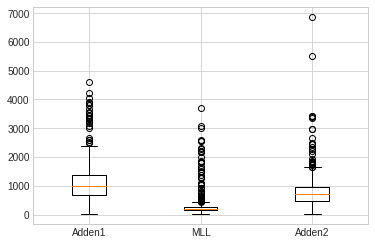

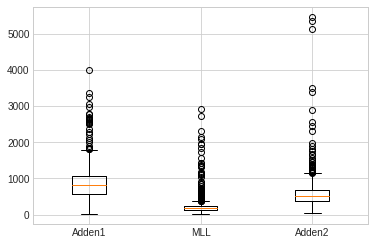

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

bp = plt.boxplot([all_lab_post[k]['original'] for k in all_lab_post])

ax.set_xticklabels([k for k in all_lab_post])

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)

bp = plt.boxplot([all_lab_post[k]['prediction'] for k in all_lab_post])

ax.set_xticklabels([k for k in all_lab_post])

plt.show()

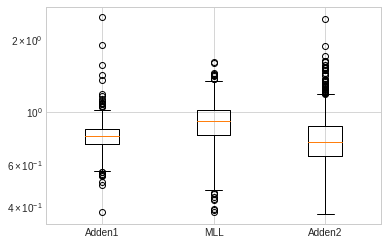

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

bp = plt.boxplot([np.array(all_lab_post[k]['prediction'])/np.array(all_lab_post[k]['original'])
                  for k in all_lab_post])

ax.set_xticklabels([k for k in all_lab_post])

ax.set_yscale('log')

plt.show()

## Example images

In [12]:
h,w = 512,1024
r = 1
border = 8

n_tiles = [12,12]

big_image = np.zeros(
    (n_tiles[0] * (h // r + border*2),n_tiles[1] * (w // r + border*2),3),
    dtype=np.uint8)

for curr_dataset in ['MLL','Adden1','Adden2']:#predictions:
    all_keys = list(predictions[curr_dataset].keys())
    all_keys = np.random.choice(all_keys,n_tiles[0]*n_tiles[1],
                                replace=False)
    print(curr_dataset)
    for i,key in enumerate(all_keys):
        image = predictions[curr_dataset][key]['image'][()]
        prediction = rescale(predictions[curr_dataset][key]['prediction'][()])

        image = np.uint8(image * 255)
        prediction = np.uint8(prediction * 255)
        
        compounded_image = np.concatenate([image,prediction],axis=1)[::r,::r]
        
        a,b = i // n_tiles[0],i % n_tiles[1]
        a *= h//r + border * 2
        b *= w//r + border * 2
        A,B,C,D = a+border,a+h//r+border,b+border,b+w//r+border
        big_image[A:B,C:D] = compounded_image
        
    Image.fromarray(big_image).save('{}.png'.format(curr_dataset))

MLL
Adden1
Adden2
